# Distilling the Knowledge in a Neural Network
# 在神经网络中提取知识

# Abstract
# 摘要
A very simple way to improve the performance of almost any machine learning algorithm is to train many different models on the same data and then to average their predictions. Unfortunately, making predictions using a whole ensemble of models is cumbersome and may be too computationally expensive to allow deployment to a large number of users, especially if the individual models are large neural nets. Caruana and his collaborators have shown that it is possible to compress the knowledge in an ensemble into a single model which is much easier to deploy and we develop this approach further using a different compression technique. We achieve some surprising results on MNIST and we show that we can significantly improve the acoustic model of a heavily used commercial system by distilling the knowledge in an ensemble of models into a single model. We also introduce a new type of ensemble composed of one or more full models and many specialist models which learn to distinguish fine-grained classes that the full models confuse. Unlike a mixture of experts, these specialist models can be trained rapidly and in parallel.

提高几乎所有机器学习算法性能的一个非常简单的方法是，在相同的数据上训练许多不同的模型，然后对它们的预测进行平均。不幸的是，使用整个模型集合进行预测是很麻烦的，而且可能在计算上过于昂贵，不允许部署到大量用户，特别是如果单个模型是大型的神经网络。Caruana和他的合作者已经证明，在一个集成系统中，将知识压缩成一个更容易部署的单一模型是可能的，我们使用不同的压缩技术进一步开发了这种方法。我们在MNIST上获得了一些令人惊讶的结果，并且我们表明，我们可以通过将模型集合中的知识提炼为单个模型来显著改进一个频繁使用的商业系统的声学模型。我们还介绍了一种新的集成类型，它由一个或多个完整模型和许多专家模型组成，这些专家模型学会区分被完整模型混淆的细粒度类。与专家的混合不同，这些专家模型可以快速并行地进行训练。

# 1 Introduction
# 介绍
Many insects have a larval form that is optimized for extracting energy and nutrients from the environment and a completely different adult form that is optimized for the very different requirements of traveling and reproduction. In large-scale machine learning, we typically use very similar models for the training stage and the deployment stage despite their very different requirements: For tasks like speech and object recognition, training must extract structure from very large, highly redundant datasets but it does not need to operate in real time and it can use a huge amount of computation. Deployment to a large number of users, however, has much more stringent requirements on latency and computational resources. The analogy with insects suggests that we should be willing to train very cumbersome models if that makes it easier to extract structure from the data. The cumbersome model could be an ensemble of separately trained models or a single very large model trained with a very strong regularizer such as dropout. Once the cumbersome model has been trained, we can then use a different kind of training, which we call “distillation” to transfer the knowledge from the cumbersome model to a small model that is more suitable for deployment. A version of this strategy has already been pioneered by Rich Caruana and his collaborators. In their important paper they demonstrate convincingly that the knowledge acquired by a large ensemble of models can be transferred to a single small model.

许多昆虫的幼虫形式是为了从环境中获取能量和营养而优化的，而完全不同的成虫形式是为了满足旅行和繁殖的不同需求而优化的。在大规模机器学习,我们通常使用非常相似的模型训练阶段和部署阶段尽管他们截然不同的要求:语音和目标识别等任务,训练必须从很大,高度冗余的数据集提取结构,但它不需要实时操作,它可以使用大量的计算。然而，部署到大量用户对延迟和计算资源有更严格的要求。与昆虫的类比表明，如果能够更容易地从数据中提取结构，我们应该愿意训练非常繁琐的模型。繁琐的模型可以是一个单独训练的模型的集合，也可以是一个单独的非常大的模型，训练一个非常强大的正则化器，如dropout。一旦对繁琐的模型进行了训练，我们就可以使用另一种训练，我们称之为“蒸馏”，将知识从繁琐的模型转移到更适合部署的小模型。这种策略的一个版本已经由里奇·卡鲁阿纳和他的合作者率先提出。在他们的重要论文中，他们令人信服地证明，由一个大的模型集合所获得的知识可以转移到一个小的模型中。

A conceptual block that may have prevented more investigation of this very promising approach is that we tend to identify the knowledge in a trained model with the learned parameter values and this makes it hard to see how we can change the form of the model but keep the same knowledge. A more abstract view of the knowledge, that frees it from any particular instantiation, is that it is a learned mapping from input vectors to output vectors. For cumbersome models that learn to discriminatebetween a large number of classes, the normal training objective is to maximize the average log probability of the correct answer, but a side-effect of the learning is that the trained model assigns probabilities to all of the incorrect answers and even when these probabilities are very small, some of them are much larger than others. The relative probabilities of incorrect answers tell us a lot abouthow the cumbersome model tends to generalize. An image of a BMW, for example, may only have a very small chance of being mistaken for a garbage truck, but that mistake is still many times more probable than mistaking it for a carrot.

概念块,可能阻止了更多的调查非常有前途的方法是,我们倾向于确定的知识与学习训练模型参数值,这使得它很难看出我们可以改变模型的形式,但保持相同的知识。知识的一个更抽象的观点是，它是从任何特定的实例化中解放出来的，它是一个从输入向量到输出向量的习得的映射。学会区分繁琐的模型,大量的类,正常的训练目标是最大化的平均对数概率正确答案,但学习的副作用是,训练模型分配概率的所有不正确的答案,即使这些概率非常小,他们中的一些人比其他人更大。不正确答案的相对概率很好地说明了这个繁琐的模型是如何泛化的。例如，一辆宝马的图像被误认为是垃圾车的可能性非常小，但这种可能性仍然是把它误认为是胡萝卜的许多倍。

It is generally accepted that the objective function used for training should reflect the true objective of the user as closely as possible. Despite this, models are usually trained to optimize performance on the training data when the real objective is to generalize well to new data. It would clearly be better to train models to generalize well, but this requires information about the correct way to generalize and this information is not normally available. When we are distilling the knowledge from a large model into a small one, however, we can train the small model to generalize in the same way as the large model. If the cumbersome model generalizes well because, for example, it is the average of a large ensemble of different models, a small model trained to generalize in the same way will typically do much better on test data than a small model that is trained in the normal way on the same training set as was used to train the ensemble.

人们普遍认为，用于训练的目标函数应尽可能地反映用户的真正目标。尽管如此，当真正的目标是很好地泛化新数据时，模型通常被训练来优化训练数据的性能。很明显，训练模型更好地泛化，但是这需要关于正确泛化方法的信息，而这些信息通常是不可用的。然而，当我们将知识从大型模型提取到小型模型时，我们可以训练小型模型以与大型模型相同的方式进行泛化。如果概括因为繁琐的模型,例如,它是一个大型的平均合奏不同的模型,一个小模型训练概括以同样的方式通常会做得更好在测试数据比正常的小模型训练方法在相同的训练集用于训练。

An obvious way to transfer the generalization ability of the cumbersome model to a small model is to use the class probabilities produced by the cumbersome model as “soft targets” for training the small model. For this transfer stage, we could use the same training set or a separate “transfer” set. When the cumbersome model is a large ensemble of simpler models, we can use an arithmetic or geometric mean of their individual predictive distributions as the soft targets. When the soft targets have high entropy, they provide much more information per training case than hard targets and much less variance in the gradient between training cases, so the small model can often be trained on much less data than the original cumbersome model and using a much higher learning rate.

将繁琐模型的泛化能力转化为小模型的一个明显方法是将繁琐模型产生的类概率作为训练小模型的“软目标”。对于这个转移阶段，我们可以使用相同的训练集，也可以使用单独的“转移”集。当繁琐的模型是大量简单模型的集合时，我们可以使用它们各自预测分布的算术或几何平均值作为软目标。当软目标有很高的熵,他们提供更多的信息每个训练样本比硬目标和更少的方差之间的梯度训练情况,所以小模型通常可以训练更少的数据比原来繁琐的模型和使用更高的学习速率。

For tasks like MNIST in which the cumbersome model almost always produces the correct answer with very high confidence, much of the information about the learned function resides in the ratios of very small probabilities in the soft targets. For example, one version of a 2 may be given a probability of 10¤6 of being a 3 and 10¤9 of being a 7 whereas for another version it may be the other way around. This is valuable information that defines a rich similarity structure over the data (i. e. it says which 2’s look like 3’s and which look like 7’s) but it has very little influence on the cross-entropy cost function during the transfer stage because the probabilities are so close to zero. Caruana and his collaborators circumvent this problem by using the logits (the inputs to the final softmax) rather than the probabilities produced by the softmax as the targets for learning the small model and they minimize the squared difference between the logits produced by the cumbersome model and the logits produced by the small model. Our more general solution, called “distillation”, is to raise the temperature of the final softmax until the cumbersome model produces a suitably soft set of targets. We then use the same high temperature when training the small model to match these soft targets. We show later that matching the logits of the cumbersome model is actually a special case of distillation.

对于MNIST这样的任务，繁琐的模型几乎总是能以非常高的置信度得出正确的答案，关于所学习函数的大部分信息都存在于软目标中极小概率的比率中。比如，一个版本的2可以被判定为10¤6的3型，10¤9的7型，而另一个版本的2可以被判定为10¤6的7型。这是有价值的信息，它定义了数据上丰富的相似结构(即，它说哪个2看起来像3，哪个像7)，但它对传输阶段的交叉熵成本函数影响很小，因为概率非常接近于零。卡鲁阿纳和他的合作者绕过这个问题通过使用分对数(输入到最终softmax)而不是将softmax产生的概率作为学习的目标小模型和他们减少平方分对数之间的差异产生的麻烦小产生的模型和分对数模型。我们的更通用的解决方案，称为“蒸馏”，是提高最终的softmax的温度，直到繁琐的模型产生一个适当的软目标集。然后，我们使用相同的高温训练小模型来匹配这些软目标。稍后我们将说明，匹配繁琐模型的日志实际上是蒸馏的一个特殊情况。

The transfer set that is used to train the small model could consist entirely of unlabeled data or we could use the original training set. We have found that using the original training set works well, especially if we add a small term to the objective function that encourages the small model to predict the true targets as well as matching the soft targets provided by the cumbersome model. Typically, the small model cannot exactly match the soft targets and erring in the direction of the correct answer turns out to be helpful.

转移设置用于训练小模型完全由无标号数据或者我们可以使用原始训练集。我们发现,使用原始训练集是有效的,特别是如果我们添加一个任期的目标函数,鼓励小模型来预测真正的目标以及匹配提供的软目标笨重的模型。通常，小模型不能准确地匹配软目标，在正确答案的方向上的错误是有帮助的。


# Distillation
# 蒸馏

Neural networks typically produce class probabilitiesbyusinga“softmax”outputlayerthatconverts the logit, zi , computed for each class into a probability, qi , by comparing zi with the other logits.

神经网络通常通过使用“softmax”输出层生成类概率，该输出层通过将zi与其他logit进行比较，将每个类计算出的logit zi转换为概率qi。


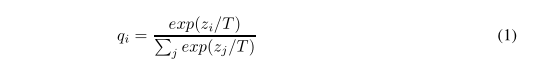

where T is a temperature that is normally set to 1. Using a higher value for T produces a softer probability distribution over classes.

其中T是通常设置为1的温度。对T使用更高的值会产生更柔和的类概率分布。

In the simplest form of distillation, knowledge is transferred to the distilled model by training it on a transfer set and using a soft target distribution for each case in the transfer set that is produced by using the cumbersome model with a high temperature in its softmax. The same high temperature is used when training the distilled model, but after it has been trained it uses a temperature of 1.

在最简单的蒸馏形式中，知识通过在一个转移集上对其进行训练并对转移集中的每个案例使用一个软目标分布来转移到被蒸馏的模型中，转移集中的每个案例都是使用在其softmax中具有高温的繁琐模型生成的。当训练被蒸馏的模型时，使用相同的高温，但是在它被训练之后，它使用的温度是1。

When the correctlabels are knownfor all or some ofthe transfer set, this methodcan besignificantly improved by also training the distilled model to produce the correct labels. One way to do this is to use the correct labels to modify the soft targets, but we found that a better way is to simply use a weighted average of two different objective functions. The first objective function is the cross entropy with the soft targets and this cross entropy is computed using the same high temperature in the softmax of the distilled model as was used for generating the soft targets from the cumbersome model. The second objective function is the cross entropy with the correct labels. This is computed using exactly the same logits in softmax of the distilled model but at a temperature of 1. We found that the best results were generally obtained by using a condiderably lower weight on the second objective function. Since the magnitudes of the gradients produced by the soft targets scale as 1/T^2 it is important to multiply them by T^2 when using both hard and soft targets. This ensures that the relative contributions of the hard and soft targets remain roughly unchanged if the temperature used for distillation is changed while experimenting with meta-parameters

当已知全部或部分转移集的正确标签时，还可以通过训练提取出的模型来生成正确的标签，从而显著改进该方法。一种方法是使用正确的标签来修改软目标，但我们发现更好的方法是简单地使用两个不同目标函数的加权平均值。第一个目标函数是与软目标的交叉熵，该交叉熵的计算方法与从繁琐模型生成软目标所用的方法相同，都是使用经过蒸馏的模型的softmax中的高温。第二个目标函数是带有正确标签的交叉熵。这是计算使用完全相同的logits在softmax的蒸馏模型，但在温度为1。我们发现，最好的结果通常是通过对第二个目标函数使用适当较低的权重来获得的。由于软目标产生的梯度大小为1/T^2，因此在使用硬目标和软目标时，将其乘以T^2是很重要的。这确保了在使用元参数进行实验时，如果用于蒸馏的温度发生变化，则硬目标和软目标的相对贡献大致保持不变。

## 2.1 Matching logits is a special case of distillation
## 2.1 匹配logits是蒸馏的一个特例

Each case in the transfer set contributes a cross-entropy gradient, dC/dzi , with respect to each logit, zi of the distilled model. If the cumbersome model has logits vi which produce soft target probabilities pi and the transfer training is done at a temperature of T, this gradient is given by:

转移集中的每个情况都提供了一个交叉熵梯度，dC/dzi，相对于每个logit, zi的蒸馏模型。如果繁琐的模型有logits vi，产生软目标概率pi，在温度为T时进行转移训练，则该梯度为:
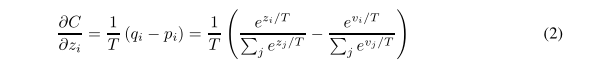

If the temperature is high compared with the magnitude of the logits, we can approximate:
如果温度比对数的大小高，我们可以近似:
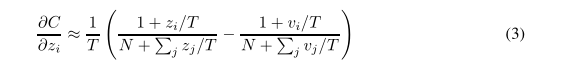

If we now assume that the logits have been zero-meaned separately for each transfer case so that Pj zj = Pj vj = 0 Eq. simplifies to:

如果我们现在假设对于每个转移的情况，logit分别是零均值的，那么Pj zj = Pj vj = 0 Eq.化简为:

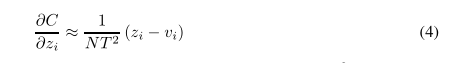

So in the high temperature limit, distillation is equivalent to minimizing 1/2(zi −vi )^2 , provided the logits are zero-meaned separately for each transfer case. At lower temperatures, distillation pays much less attention to matching logits that are much more negative than the average. This is potentially advantageous because these logits are almost completely unconstrained by the cost function used for training the cumbersome model so they could be very noisy. On the other hand, the very negative logits may convey useful information about the knowledge acquired by the cumbersome model. Which of these effects dominates is an empirical question. We show that when the distilled model is much too small to capture all of the knowledege in the cumbersome model, intermediate temperatures work best which strongly suggests that ignoring the large negative logits can be helpful.

因此，在高温极限下，蒸馏相当于使1/2(zi−vi)^2最小化，前提是每个转移情况的logit分别为零。在较低的温度下，蒸馏对比平均值负得多的对数匹配的关注要少得多。这可能是有利的，因为这些逻辑几乎完全不受用于训练繁琐模型的成本函数的约束，因此它们可能非常嘈杂。另一方面，非常负面的日志可能传递关于通过繁琐的模型获得的知识的有用信息。这些影响中哪一个占主导地位是一个经验问题。我们发现，当提取出的模型太小，无法在繁琐的模型中获取所有知识时，中间温度的效果最好，这有力地说明忽略较大的负对数是有帮助的。


# 3 Preliminary experiments on MNIST
# 3 在MNIST初步实验

To see how well distillation works, we trained a single large neural net with two hidden layers of 1200 rectified linear hidden units on all 60,000 training cases. The net was strongly regularized usingdropoutandweight-constraintsas describedin. Dropoutcan beviewedas a way oftraining an exponentially large ensemble of models that share weights. In addition, the input images were jittered by up to two pixels in any direction. This net achieved 67 test errors whereas a smaller net with two hidden layers of 800 rectified linear hidden units and no regularization achieved 146 errors. But if the smaller net was regularized solely by adding the additional task of matching the soft targets produced by the large net at a temperature of 20, it achieved 74 test errors. This shows that soft targets can transfer a great deal of knowledge to the distilled model, including the knowledge about how to generalize that is learned from translated training data even though the transfer set does not contain any translations.

为了了解精馏是如何工作的，我们训练了一个大型的神经网络，它有两个隐藏层，包含1200个蒸馏后的线性隐藏单元，总共有60000个训练案例。如所述，该网络采用了强正则化的dropout和weight约束。dropout可以被看作是一种训练指数级大的共享权重的模型集合的方法。此外，输入的图像在任何方向上都有多达两个像素的抖动。这个网络实现了67个测试误差，而一个较小的网络，有两个隐层，800个直线隐单元，没有正则化，实现了146个误差。但是，如果仅仅通过增加与大网络在20℃时产生的软目标匹配的额外任务来对较小的网络进行正则化，则可以获得74个测试错误。这表明，软目标可以将大量的知识转移到提取的模型中，包括如何从转移后的训练数据中学习泛化的知识，即使转换集不包含任何翻译。

When the distilled net had 300 or more units in each of its two hidden layers, all temperatures above 8 gave fairly similar results. But when this was radically reduced to 30 units per layer, temperatures in the range 2.5 to 4 worked significantly better than higher or lower temperatures.

当蒸馏网的两个隐藏层各有300个或更多的单元时，所有高于8的温度都给出了相当相似的结果。但当这一温度被大幅降低到每层30个单位时，2.5到4摄氏度的温度明显比更高或更低的温度效果更好。

We then tried omitting all examples of the digit 3 from the transfer set. So from the perspective of the distilled model, 3 is a mythical digit that it has never seen. Despite this, the distilled model only makes 206 test errors of which 133 are on the 1010 threes in the test set. Most of the errors are caused by the fact that the learned bias for the 3 class is much too low. If this bias is increased by 3.5 (which optimizes overall performance on the test set), the distilled model makes 109 errors of which 14 are on 3s. So with the right bias, the distilled model gets 98.6% of the test 3s correct despite never having seen a 3 during training. If the transfer set contains only the 7s and 8s from the training set, the distilled model makes 47.3% test errors, but when the biases for 7 and 8 are reduced by 7.6 to optimize test performance, this falls to 13.2% test errors.

然后，我们尝试从传输集中省略所有数字3的例子。因此，从经过提炼的模型的角度来看，3是一个虚构的数字，它从未见过。尽管如此，经过提炼的模型只产生了206个测试错误，其中133个在测试集中的1010个3位上。大多数错误是由于3类的学习偏差太低造成的。如果这个偏差增加了3.5(这优化了测试集的整体性能)，那么经过蒸馏的模型会产生109个错误，其中14个错误出现在3s上。因此，在正确的偏差下，尽管在训练中从未见过3，但经过提炼的模型得到了98.6%的测试3的正确率。如果转移集只包含训练集中的7s和8s，则经过蒸馏的模型产生了47.3%的测试误差，但当为优化测试性能而将7和8的偏差降低7.6时，这一误差降至13.2%。

# 4 Experiments on speech recognition
# 4 语音识别实验

In this section, we investigate the effects of ensembling Deep Neural Network (DNN) acoustic models that are used in Automatic Speech Recognition (ASR). We show that the distillation strategy that we propose in this paper achieves the desired effect of distilling an ensemble of models into a single model that works significantly better than a model of the same size that is learned directly from the same training data.

在这一节中，我们研究了集成深度神经网络(DNN)声学模型在自动语音识别(ASR)中的作用。我们证明，我们在本文中提出的精馏策略达到了预期的效果，即将一个模型集合精馏为一个单独的模型，该模型比直接从相同的训练数据学习相同大小的模型工作得好得多。

State-of-the-art ASR systems currently use DNNs to map a (short) temporal context of features derived from the waveform to a probability distribution over the discrete states of a Hidden Markov Model (HMM). More specifically, the DNN produces a probability distribution over clusters of tri-phone states at each time and a decoder then finds a path through the HMM states that is the best compromise between using high probability states and producing a transcription that is probable under the language model.

目前最先进的ASR系统使用DNNs将(短)时间内的波形特征映射到隐马尔可夫模型(HMM)的离散状态上的概率分布。更具体地说，DNN每次都在三音状态的集群上产生一个概率分布，然后解码器找到一条通过HMM状态的路径，这是使用高概率状态和在语言模型下产生可能的转录之间的最佳折衷。

Although it is possible (and desirable) to train the DNN in such a way that the decoder (and, thus, the language model) is taken into account by marginalizing over all possible paths, it is common to train the DNN to perform frame-by-frame classification by (locally) minimizing the cross entropy between the predictions made by the net and the labels given by a forced alignment with the ground truth sequence of states for each observation:

虽然它是可能的(理想的)训练款以这样一种方式,解码器(,因此,语言模型)被边缘化在考虑所有可能的路径,通常培训款执行帧分类(本地)最小化之间的交叉熵预测净和标签由强制对齐与地面真理为每个观测序列的状态:

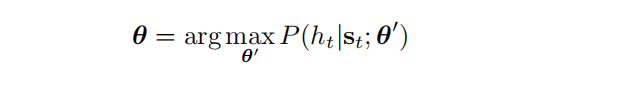


where θ are the parameters of our acoustic model P which maps acoustic observations at time t, st, to a probability, P(ht|st; θ′) , of the “correct” HMM state ht, which is determined by a forced alignment with the correct sequence of words. The model is trained with a distributed stochastic gradient descent approach.

θ在哪里我们的声学模型的参数P地图声学观测在时间t, st,概率,P (ht |st;θ′),ht“正确”HMM状态,是由强制对齐与正确的单词序列。该模型采用分布式随机梯度下降法进行训练。

We use an architecture with 8 hidden layers each containing 2560 rectified linear units and a final softmax layer with 14,000 labels (HMM targets ht). The input is 26 frames of 40 Mel-scaled filterbank coefficients with a 10ms advance per frame and we predict the HMM state of 21st frame. The total number of parameters is about 85M. This is a slightly outdated version of the acoustic model used by Android voice search, and should be considered as a very strong baseline. To train the DNN acoustic model we use about 2000 hours of spoken English data, which yields about 700M training examples. This system achieves a frame accuracy of 58.9%, and a Word Error Rate (WER) of 10.9% on our development set.

我们使用的架构有8个隐藏层，每个包含2560个直线单元，最后一个带有14000个标签的softmax层(HMM目标ht)。输入是26帧，每帧40个mel比例的滤波器组系数，每帧提前10ms，我们预测第21帧的HMM状态。参数总数约为85M。这是Android语音搜索使用的声学模型的一个稍微过时的版本，应该被视为一个非常强大的基线。为了训练DNN声学模型，我们使用了大约2000小时的英语口语数据，这产生了大约7亿个训练实例。在我们的开发集中，该系统实现了58.9%的帧精度和10.9%的单词错误率(WER)。

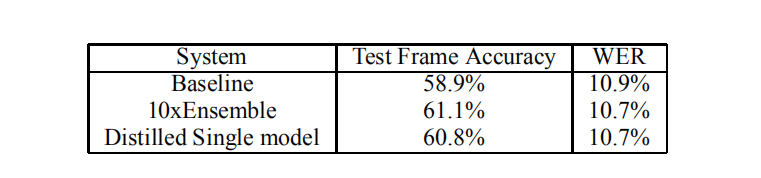

Table 1: Frame classification accuracy and WER showing that the distilled single model performs about as well as the averaged predictions of 10 models that were used to create the soft targets.

表1:帧分类精度和WER表明，所提取的单个模型的性能与用于创建软目标的10个模型的平均预测性能相当。


# 4  Results
# 4 结果

We trained 10 separate models to predict P(ht|st; θ), using exactly the same architecture and training procedure as the baseline. The models are randomly initialized with different initial parameter values and we find that this creates sufficient diversity in the trained models to allow the averaged predictions of the ensemble to significantly outperform the individual models. We have explored adding diversity to the models by varying the sets of data that each model sees, but we found this to not significantly change our results, so we opted for the simpler approach. For the distillation we tried temperatures of [1, 2, 5, 10] and used a relative weight of 0.5 on the cross-entropy for the hard targets, where bold font indicates the best value that was used for table 1 .

我们训练了10个独立的模型来预测P(ht|st;θ),使用完全相同的体系结构和训练过程作为基线。模型被随机初始化，初始参数值不同，我们发现这在训练的模型中产生了足够的多样性，使得总体的平均预测显著优于单个模型。我们已经探索了通过改变每个模型看到的数据集来增加模型的多样性，但是我们发现这并没有显著地改变我们的结果，所以我们选择了更简单的方法。对于蒸馏，我们尝试了[1,2,5,10]的温度，并对硬目标的交叉熵使用了0.5的相对权重，其中粗体表示表1使用的最佳值。

Table 1 shows that, indeed, our distillation approach is able to extract more useful information from the training set than simply using the hard labels to train a single model. More than 80% of the improvement in frame classification accuracy achieved by using an ensemble of 10 models is transferred to the distilled model which is similar to the improvement we observed in our preliminary experiments on MNIST. The ensemble gives a smaller improvement on the ultimate objective of WER (on a 23K-word test set) due to the mismatch in the objective function, but again, the improvement in WER achieved by the ensemble is transferred to the distilled model.

表1显示，实际上，我们的精馏方法能够从训练集中提取更多有用的信息，而不是简单地使用硬标签来训练单个模型。使用10个模型的集合所获得的帧分类精度改进的80%以上被转移到提取的模型中，这与我们在MNIST上的初步实验中观察到的改进相似。由于目标函数的不匹配，集成对WER的最终目标(在一个23k单词的测试集上)的改进较小，但是集成所实现的WER的改进再次转移到经过蒸馏的模型中。

We have recently become aware of related work on learning a small acoustic model by matching the class probabilities of an already trained larger model. However, they do the distillation at a temperature of 1 using a large unlabeled dataset and their best distilled model only reduces the error rate of the small model by 28% of the gap between the error rates of the large and small models when they are both trained with hard labels.

最近，我们注意到通过匹配已经训练过的更大模型的类概率来学习小声学模型的相关工作。然而,他们做的蒸馏温度1使用大型无标号数据集和最好的蒸馏模型只减少了错误率小模型的28%的错误率之间的差距的大型和小型模型当他们都是训练有素的硬标签。





# 5  Training ensembles of specialists on very big datasets
# 5 在非常大的数据集上训练专家的集合

Training an ensemble of models is a very simple way to take advantage of parallel computation and the usual objection that an ensemble requires too much computation at test time can be dealt with by using distillation. There is, however, another important objection to ensembles: If the individual models are large neural networks and the dataset is very large, the amount of computation required at training time is excessive, even though it is easy to parallelize.

训练一个模型集合是利用并行计算的一种非常简单的方法，通常的反对意见是，一个集合在测试时需要太多的计算，可以通过使用蒸馏来处理。然而，对集成还有另一个重要的反对意见:如果单个模型是大型神经网络，数据集非常大，那么在训练时所需的计算量是过多的，尽管它很容易并行化。

In this section we give an example of such a dataset and we show how learning specialist models that each focus on a different confusable subset of the classes can reduce the total amount of computation required to learn an ensemble. The main problem with specialists that focus on making fine-grained distinctions is that they overfit very easily and we describe how this overfitting may be prevented by using soft targets.

在本节中，我们给出了这样一个数据集的例子，并展示了学习专家模型(每个模型都关注类的不同可混淆子集)如何减少学习集成所需的总计算量。专注于细粒度区分的专家的主要问题是他们很容易过度拟合，我们描述了如何通过使用软目标来防止这种过度拟合。

## 5.1 The JFT dataset
## 5.1 JFT 数据集

JFT is an internal Google dataset that has 100 million labeled images with 15,000 labels. When we did this work, Google’s baseline model for JFT was a deep convolutional neural network that had been trained for about six months using asynchronous stochastic gradient descent on a large number of cores. This training used two types of parallelism . First, there were many replicas of the neural net running on different sets of cores and processing different mini-batches from the training set. Each replica computes the average gradient on its current mini-batch and sends this gradient to a sharded parameter server which sends back new values for the parameters. These new values reflect all of the gradients received by the parameter server since the last time it sent parameters to the replica. Second, each replica is spread over multiple cores by putting different subsets of the neurons on each core. Ensemble training is yet a third type of parallelism that can be wrapped around the other two types, but only if a lot more cores are available. Waiting for several years to train an ensemble of models was not an option, so we needed a much faster way to improve the baseline model.

JFT是一个内部的谷歌数据集，它有1亿个带有15,000个标签的图像。当我们做这项工作时，谷歌的JFT基线模型是一个深度卷积神经网络，它已经在大量核心上使用异步随机梯度下降训练了大约6个月。这种训练使用了两种并行性。首先，神经网络的多个副本运行在不同的核集上，并处理来自训练集的不同小批处理。每个副本计算当前小批处理的平均梯度，并将该梯度发送到分片参数服务器，该服务器将返回参数的新值。这些新值反映了自上次将参数发送到副本以来，参数服务器接收到的所有梯度。其次，每个副本通过在每个核上放置不同的神经元子集而分布在多个核上。集成训练仍然是第三种并行性，它可以封装在其他两种类型上，但前提是有更多可用的核心。等待几年来训练一个模型集合是不可取的，所以我们需要一个更快的方法来改进基线模型。
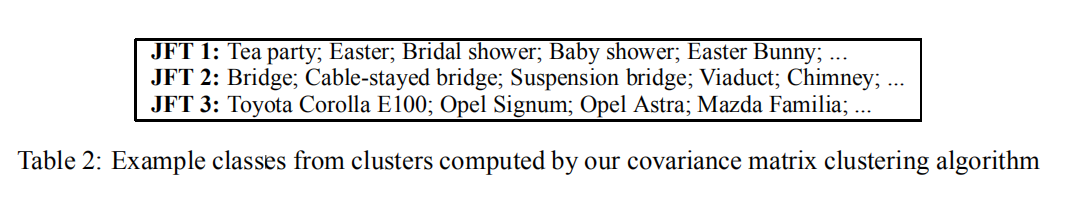

## 5.2 Specialist Models
## 5.2 专家模型

When the number of classes is very large, it makes sense for the cumbersome model to be an ensemble that contains one generalist model trained on all the data and many “specialist” models, each of which is trained on data that is highly enriched in examples from a very confusable subset of the classes (like different types of mushroom). The softmax of this type of specialist can be made much smaller by combining all of the classes it does not care about into a single dustbin class.

当类的数量是非常大的,它是有意义的笨重的模型是一个整体,它包含一个多面手模型训练的所有数据和许多“专家”模型,其中每个训练数据是高纯度的例子从一个很可能被混淆的子集类(如不同类型的蘑菇)。这种类型的专家的softmax可以通过将它不关心的所有类合并到一个单一的垃圾箱类中而变得更小。


To reduce overfitting and share the work of learning lower level feature detectors, each specialist model is initialized with the weights of the generalist model. These weights are then slightly modified by training the specialist with half its examples coming from its special subset and half sampled at random from the remainder of the training set. After training, we can correct for the biased training set by incrementing the logit of the dustbin class by the log of the proportion by which the specialist class is oversampled.

为了减少过度拟合和分担学习低层特征检测器的工作，每个专家模型都初始化了泛型模型的权值。这些重量略修改培训专家,一半一半的例子来自于其特殊的子集随机抽样从剩下的训练集,训练后,我们可以纠正偏见训练集的递增分对数垃圾箱日志类的专业类的比例是采样过量。


## 5.3 Assigning classes to specialists
## 5.3 为专家分配类

In order to derive groupings of object categories for the specialists, we decided to focus on categories that our full network often confuses. Even though we could have computed the confusion matrix and used it as a way to find such clusters, we opted for a simpler approach that does not require the true labels to construct the clusters.

为了为专家派生对象类别的分组，我们决定将重点放在我们的整个网络经常混淆的类别上。尽管我们可以计算混淆矩阵并将其用作查找此类集群的一种方法，但我们选择了一种更简单的方法，这种方法不需要真正的标签来构建集群。

In particular, we apply a clustering algorithm to the covariance matrix of the predictions of our generalist model, so that a set of classes Sm that are often predicted together will be used as targets for one of our specialist models, m. We applied an on-line version of the K-means algorithm to the columns of the covariance matrix, and obtained reasonable clusters (shown in Table 2). We tried several clustering algorithms which produced similar results.

特别是,我们一个聚类算法应用于通才的预测模型的协方差矩阵,这样一组类Sm经常一起预测将会作为我们的一个专家的目标模型,m。我们应用在线版本的K-means算法协方差矩阵的列,并获得合理的集群(见表2)。我们尝试一些聚类算法产生相似的结果。


## 5.4 Performing inference with ensembles of specialists
## 5.4 与专家团队进行推理


Before investigating what happens when specialist models are distilled, we wanted to see how well ensembles containing specialists performed. In addition to the specialist models, we always have a generalist model so that we can deal with classes for which we have no specialists and so that we can decide which specialists to use. Given an input image x, we do top-one classification in two steps:

在研究专家模型被提取时发生了什么之前，我们想看看包含专家模型的集成系统表现如何。除了专家模型之外，我们总是有一个通用模型，这样我们就可以处理没有专家的类，这样我们就可以决定使用哪些专家。给定一个输入图像x，我们分两个步骤进行top-one分类:

Step 1: For each test case, we find the n most probable classes according to the generalist model. Call this set of classes k. In our experiments, we used n = 1.

步骤1:对于每个测试用例，我们根据泛型模型找到n个最可能的类。称这组类为k。在我们的实验中，我们使用了n = 1。

Step 2: We then take all the specialist models, m, whose special subset of confusable classes, Sm, has a non-empty intersection with k and call this the active set of specialists Ak (note that this set may be empty). We then find the full probability distribution q over all the classes that minimizes:

步骤2:然后我们取所有的专家模型，m，它的可混淆类的特殊子集，Sm，与k有一个非空的交集，并称之为活跃的专家集Ak(注意这个集合可能是空的)。然后，我们找到了q在所有最小化的类上的全概率分布:

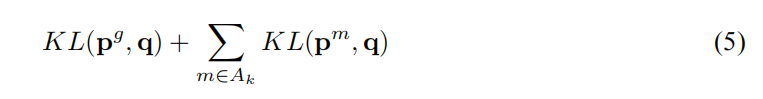

where KL denotes the KL divergence, and pm pg denote the probability distribution of a specialist model or the generalist full model. The distribution pm is a distribution over all the specialist classes of m plus a single dustbin class, so when computing its KL divergence from the full q distribution we sum all of the probabilities that the full q distribution assigns to all the classes in m’s dustbin.

其中KL表示KL散度，pm pg表示专家模型或泛型全模型的概率分布。分布pm是m的所有专家类加上一个垃圾箱类的分布，所以当计算它的KL与完整的q分布的散度时，我们把完整的q分布分配给m垃圾箱中所有类的所有概率加起来。

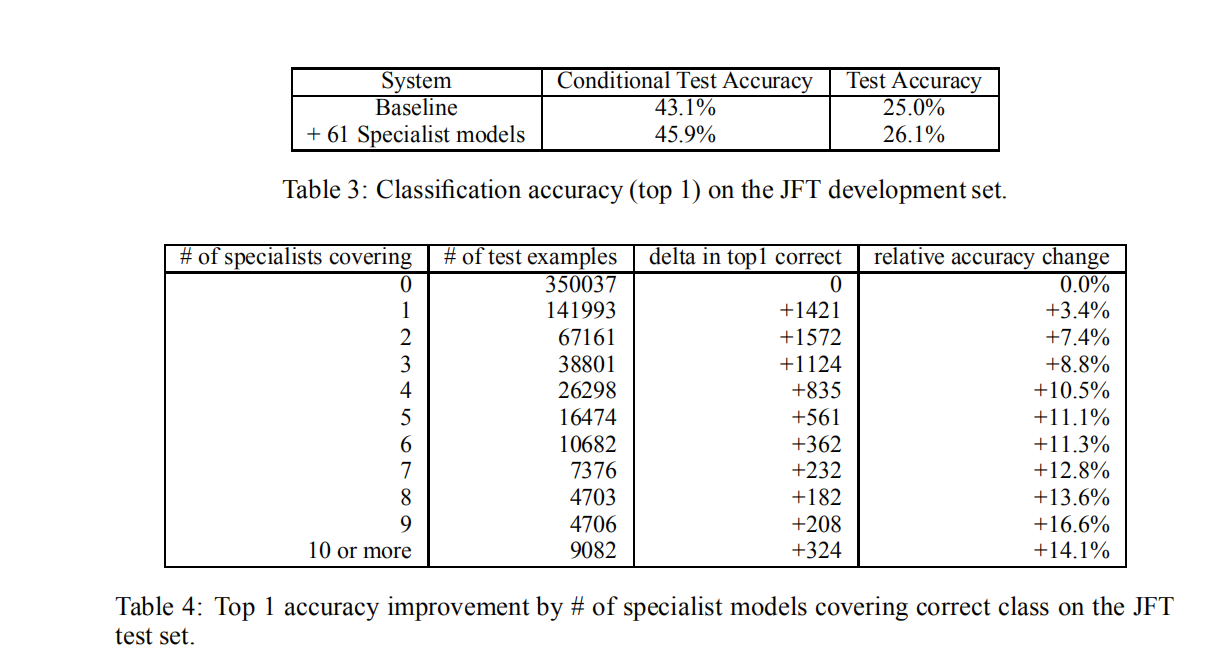

Eq. 5 does not have a general closed form solution, though when all the models produce a single probability for each class the solution is either the arithmetic or geometric mean, depending on whether we use KL(p, q) or KL(q, p)). We parameterize q = sof tmax(z) (with T = 1) and we use gradient descent to optimize the logits z w.r.t. eq. 5. Note that this optimization must be carried out for each image.

Eq. 5并没有一个通用的封闭形式的解，虽然当所有的模型对每个类产生一个单一的概率时，其解要么是算术平均值，要么是几何平均值，这取决于我们是使用KL(p, q)还是KL(q, p))。我们参数化q = sof tmax(z) (T = 1)，并使用梯度下降法优化logits z w.r.t eq. 5。请注意，必须对每个图像执行此优化。

## 5.5 Results
## 5.5 结果

Starting from the trained baseline full network, the specialists train extremely fast (a few days instead of many weeks for JFT). Also, all the specialists are trained completely independently. Table 3 shows the absolute test accuracy for the baseline system and the baseline system combined with the specialist models. With 61 specialist models, there is a 4.4% relative improvement in test accuracy overall. We also report conditional test accuracy, which is the accuracy by only considering examples belonging to the specialist classes, and restricting our predictions to that subset of classes.

从经过训练的基线全网络开始，专家们的训练速度非常快(JFT只需几天，而不是几周)。而且，所有的专家都是完全独立训练的。表3显示了基线系统和基线系统结合专家模型的绝对测试精度。有61个专家模型，总体上有4.4%的测试精度相对提高。我们还报告了条件测试的准确性，即仅考虑属于专家类的示例的准确性，并将我们的预测限制在类的子集中。

For our JFT specialist experiments, we trained 61 specialist models, each with 300 classes (plus the dustbin class). Because the sets of classes for the specialists are not disjoint, we often had multiple specialists covering a particular image class. Table 4 shows the number of test set examples, the change in the number of examples correct at position 1 when using the specialist(s), and the relative percentage improvement in top1 accuracy for the JFT dataset broken down by the number of specialists covering the class. We are encouraged by the general trend that accuracy improvements are larger when we have more specialists covering a particular class, since training independent specialist models is very easy to parallelize.

在我们的JFT专家实验中，我们训练了61个专家模型，每个模型有300个类(加上垃圾箱类)。因为专家类的集合不是不连续的，所以我们经常有多个专家覆盖一个特定的映像类。表4显示了测试集示例的数量、使用专家时在位置1处正确的示例数量的变化，以及按覆盖类的专家数量细分的JFT数据集top1准确性的相对百分比改进。当我们有更多的专家覆盖一个特定的类时，准确性的提高会更大，这一总体趋势令我们感到鼓舞，因为培训独立的专家模型非常容易并行化。


# 6 Soft Targets as Regularizers
# 6 软目标作为正则

One of our main claims about using soft targets instead of hard targets is that a lot of helpful information can be carried in soft targets that could not possibly be encoded with a single hard target. In this section we demonstrate that this is a very large effect by using far less data to fit the 85M parameters of the baseline speech model described earlier. Table 5 shows that with only 3% of the data (about 20M examples), training the baseline model with hard targets leads to severe overfitting (we did early stopping, as the accuracy drops sharply after reaching 44.5%), whereas the same model trained with soft targets is able to recover almost all the information in the full training set (about 2% shy). It is even more remarkable to note that we did not have to do early stopping: the system with soft targets simply “converged” to 57%. This shows that soft targets are a very effective way of communicating the regularities discovered by a model trained on all of the data to another model.

我们关于使用软目标而不是硬目标的一个主要主张是，许多有用的信息可以在软目标中携带，而不可能用单个硬目标编码。在本节中，我们通过使用更少的数据来拟合前面描述的基线语音模型的85M参数来证明这是一个非常大的影响。表5显示,只有3%的数据(约20米的例子),培训基线模型与硬目标会导致严重的过度拟合(我们做早期停止,精度达到44.5%之后急剧下降),而相同的模型训练与软目标能够恢复几乎所有的信息在整个训练集(大约2%害羞)。更值得注意的是，我们没有必要提前停止:系统的软目标仅仅“收敛”到57%。这表明，软目标是一种非常有效的方法，可以将在所有数据上训练的模型发现的规律传递给另一个模型。
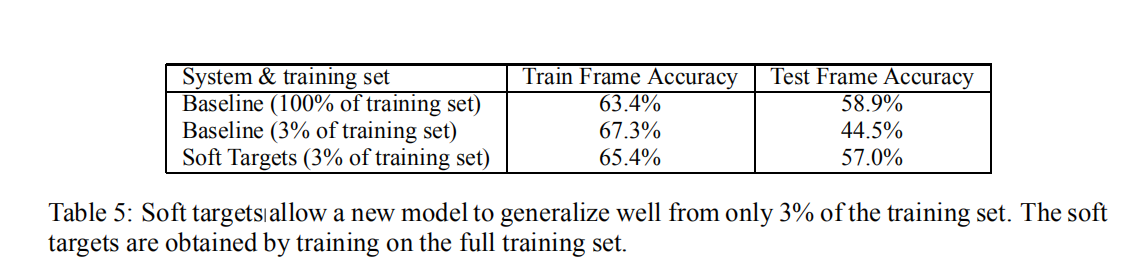

## 6.1 Using soft targets to prevent specialists from overfitting
## 6.1使用软目标防止专家过拟合

The specialists that we used in our experiments on the JFT dataset collapsed all of their non-specialist classes into a single dustbin class. If we allow specialists to have a full softmax over all classes, there may be a much better way to prevent them overfitting than using early stopping. A specialist is trained on data that is highly enriched in its special classes. This means that the effective size of its training set is much smaller and it has a strong tendency to overfit on its special classes. This problem cannot be solved by making the specialist a lot smaller because then we lose the very helpful transfer effects we get from modeling all of the non-specialist classes.

我们在JFT数据集上的实验中使用的专家将他们所有的非专业类都压缩到一个垃圾箱类中。如果我们允许专家在所有的类上都有一个完整的softmax，那么可能有一个比使用早期停止更好的方法来防止它们过度拟合。专家在其特殊课程中接受数据方面的培训，这些数据非常丰富。这意味着它的训练集的有效大小要小得多，而且它在特殊类上有过度适应的强烈倾向。这个问题不能通过缩小专家类来解决，因为这样我们就失去了从建模所有非专家类中获得的非常有用的转移效果。

Our experiment using 3% of the speech data strongly suggests that if a specialist is initialized with the weights of the generalist, we can make it retain nearly all of its knowledge about the non-special classes by training it with soft targets for the non-special classes in addition to training it with hard targets. The soft targets can be provided by the generalist. We are currently exploring this approach.

我们的实验使用3%的语音数据专家强烈建议,如果初始化权重的多面手,我们可以让它保留几乎所有的知识通过培训的非特殊的类非特殊的类的软目标除了努力训练与目标。软目标可以由通用模型提供。我们目前正在探索这种方法。




# 7 Relationship to Mixtures of Experts
# 7 .专家混合物的关系

The use of specialists that are trained on subsets of the data has some resemblance to mixtures of experts which use a gating network to compute the probability of assigning each example to each expert. At the same time as the experts are learning to deal with the examples assigned to them, the gating network is learning to choose which experts to assign each example to based on the relative discriminative performance of the experts for that example. Using the discriminative performance of the experts to determine the learned assignments is much better than simply clustering the input vectors and assigning an expert to each cluster, but it makes the training hard to parallelize: First, the weighted training set for each expert keeps changing in a way that depends on all the other experts and second, the gating network needs to compare the performance of different experts on the same example to know how to revise its assignment probabilities. These difficulties have meant that mixtures of experts are rarely used in the regime where they might be most beneficial: tasks with huge datasets that contain distinctly different subsets.

对数据子集进行训练的专家的使用与使用门控网络来计算将每个示例分配给每个专家的概率的专家混合物有一些相似之处。在专家学习处理分配给他们的示例的同时，门控网络正在学习根据专家对该示例的相对辨别性能来选择要分配给每个示例的专家。利用专家的判别性能来确定学习任务比简单地将输入向量聚类并将专家分配到每个聚类要好得多，但这使得训练很难并行化:首先，每个专家的加权训练集的变化依赖于所有其他专家，其次，选通网络需要比较不同专家在同一个例子上的表现，从而知道如何修正其分配概率。这些困难意味着，专家的混合物很少用于可能最有益的领域:包含明显不同子集的庞大数据集的任务。

It is much easier to parallelize the training of multiple specialists. We first train a generalist model and then use the confusion matrix to define the subsets that the specialists are trained on. Once these subsets have been defined the specialists can be trained entirely independently. At test time we can use the predictions from the generalist model to decide which specialists are relevant and only these specialists need to be run.

将多个专家的训练并行化要容易得多。我们首先训练一个泛型模型，然后使用混淆矩阵来定义专家所训练的子集。一旦定义了这些子集，专家就可以完全独立地进行训练。在测试时，我们可以使用来自通用模型的预测来决定哪些专家是相关的，并且只需要运行这些专家。

# 8 Discussion
# 8 讨论

We have shown that distilling works very well for transferring knowledge from an ensemble or from a large highly regularized model into a smaller, distilled model. On MNIST distillation works remarkably well even when the transfer set that is used to train the distilled model lacks any examples of one or more of the classes. For a deep acoustic model that is version of the one used by Android voice search, we have shown that nearly all of the improvement that is achieved by training an ensemble of deep neural nets can be distilled into a single neural net of the same size which is far easier to deploy.

我们已经证明，对于将知识从一个整体或从一个大型的高度正则化的模型转移到一个更小的、精练的模型中，蒸馏非常有效。在MNIST上，即使用于训练蒸馏模型的传递集缺少一个或多个类的任何示例，蒸馏仍然可以非常好地工作。深度声学模型版本的Android所使用的语音搜索,我们已经表明,几乎所有的改进是通过训练一个深层神经网络可以简化为一个相同大小的单一神经网络更容易部署。

For really big neural networks, it can be infeasible even to train a full ensemble, but we have shown that the performance of a single really big net that has been trained for a very long time can be significantly improved by learning a large number of specialist nets, each of which learns to discriminate between the classes in a highly confusable cluster. We have not yet shown that we can distill the knowledge in the specialists back into the single large net.

非常大的神经网络,它甚至可以不可行训练一个完整的整体,但我们已经表明,一个非常大的性能净已经训练了很长一段时间可以显著提高了学习大量的专业网,每个学会区分的类在一个高度可能被混淆的集群。我们还没有证明我们可以把专家们的知识提取到单一的大网络中。



# Acknowledgments
# 鸣谢
We thank Yangqing Jia for assistance with training models on ImageNet and Ilya Sutskever and Yoram Singer for helpful discussions.

我们感谢贾杨青在ImageNet和Ilya Sutskever以及Yoram Singer的训练模型上提供的帮助，为我们提供了有益的讨论。